In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

print(pm.__version__)
print(az.__version__)

5.7.2
0.16.1


In [2]:
path_train = "train_clf.csv"
path_test = "test_clf.csv"

In [3]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [4]:
df_train.describe()#делаем вывод, что y - бинарная переменная

,a,b,c,y
count,100.000000,100.000000,100.000000,100.000000
mean,4.744147,5.184609,0.565327,0.510000
std,2.661816,2.856959,2.390181,0.502418
min,0.172791,0.593243,-5.861033,0.000000
25%,2.273386,2.837524,-1.193336,0.000000
50%,4.677771,5.372579,0.262527,1.000000
75%,7.014171,7.596251,2.377493,1.000000
max,10.772372,12.440338,5.443810,1.000000


/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


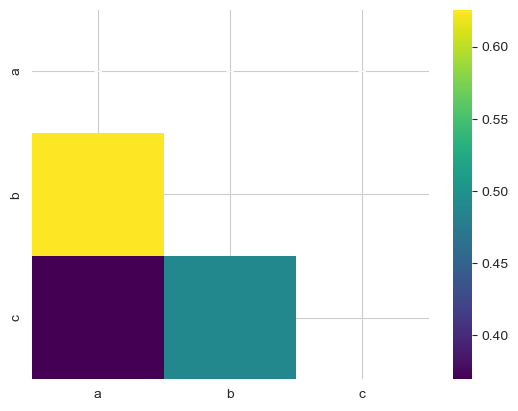

In [5]:
corr = df_train.drop(['y'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

In [6]:
features = ['a', 'b', 'c']
target = 'y'

# Подготовка данных
X_train = df_train[features].values
y_train = df_train[target].values
X_test = df_test[features].values


## Задание 1

In [7]:

# Определение модели
with pm.Model() as logistic_model:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, shape=len(features))  
    μ = α + pm.math.dot( X_train, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * X_train[:,0])
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_train) 
 
    trace = pm.sample(3000, chains = 4, cores = 4)

# Выполнение MCMC семплирования
"""with logistic_model:
    step = pm.Metropolis()
    trace = pm.sample(20000, step, progressbar=True)"""

"""# Построение предсказаний на тестовых данных
X_test_shared = pm.floatX(X_test)
with logistic_model:
    ppc = pm.sample_ppc(trace, samples=500, vars=[observed], model=logistic_model)

# Извлечение предсказаний
predicted_y = ppc['observed'].mean(axis=0)"""


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 23 seconds.


"# Построение предсказаний на тестовых данных\nX_test_shared = pm.floatX(X_test)\nwith logistic_model:\n    ppc = pm.sample_ppc(trace, samples=500, vars=[observed], model=logistic_model)\n\n# Извлечение предсказаний\npredicted_y = ppc['observed'].mean(axis=0)"

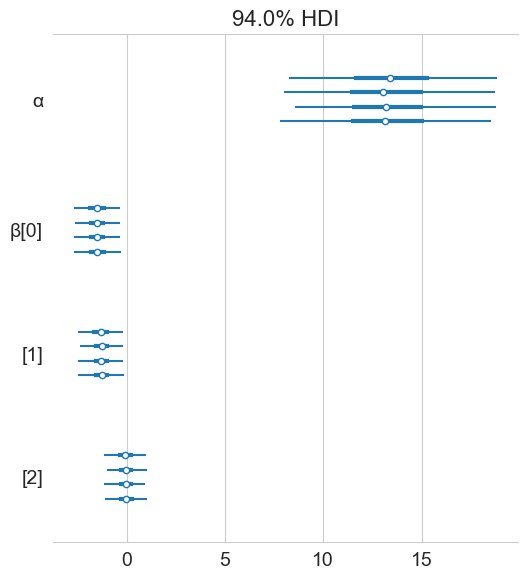

In [8]:
varnames = ['α', 'β'] 
az.plot_forest(trace, var_names=varnames);

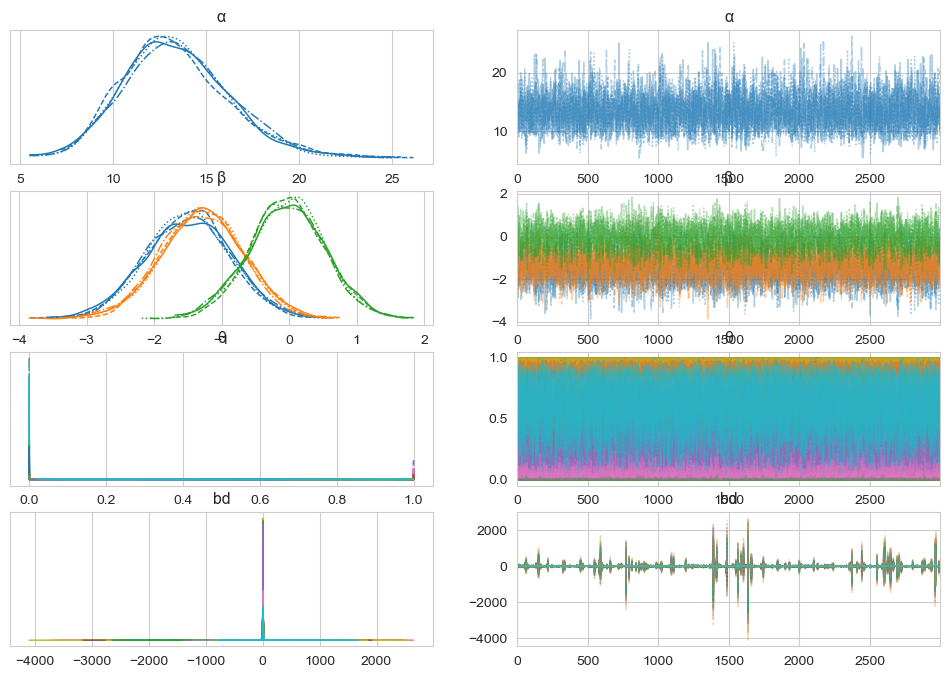

In [9]:
az.plot_trace(trace, compact=True);

In [10]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,13.419,2.873,8.189,18.777,0.047,0.033,3676.0,3432.0,1.0
β[0],-1.501,0.627,-2.684,-0.332,0.010,0.007,3667.0,3823.0,1.0
β[1],-1.291,0.606,-2.464,-0.201,0.010,0.007,3482.0,3893.0,1.0
β[2],-0.035,0.557,-1.110,1.001,0.009,0.007,3484.0,3915.0,1.0
θ[0],0.005,0.008,0.000,0.018,0.000,0.000,4725.0,5220.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],8.409,27.553,5.040,16.290,0.250,0.187,4193.0,4682.0,1.0
bd[96],2.933,21.718,-3.297,5.776,0.203,0.145,4165.0,5166.0,1.0
bd[97],1.684,32.776,-7.467,6.033,0.305,0.219,4029.0,4774.0,1.0
bd[98],10.148,42.991,4.784,22.415,0.393,0.290,4060.0,4344.0,1.0


In [11]:
a = trace.posterior['α'].mean(("chain", "draw")).values
b = trace.posterior["β"].mean(("chain", "draw")).values


z = a + np.dot(X_test, b)


predicted_probabilities = 1 / (1 + np.exp(-z))

threshold = 0.5
predicted_labels = (predicted_probabilities > threshold).astype(int)

In [12]:
predicted_labels

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [14]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, predicted_labels)

0.96

## Задание 2

In [15]:
y_0 = pd.Categorical(df_train['y']).codes
column = ['a', 'b', 'c']
x_0 = df_train[column].values

with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    zero = pm.Normal('zero', mu=μ[0], sigma=σ[0], observed=x_0[:50]) 
    one = pm.Normal('one', mu=μ[1], sigma=σ[1], observed=x_0[50:]) 
    
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


Text(0.5, 0, 'y')

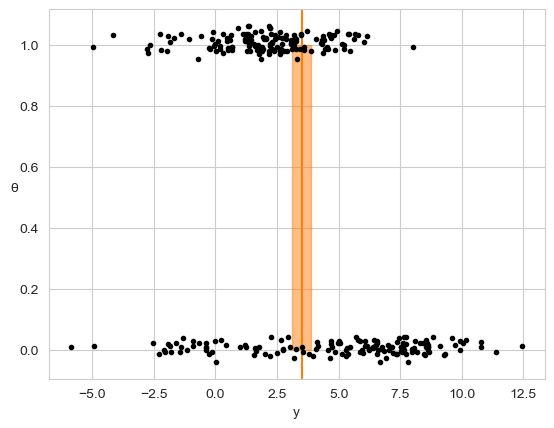

In [16]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('y')

In [17]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],3.623,0.276,3.073,4.117,0.002,0.002,14401.0,6476.0,1.0
μ[1],3.372,0.287,2.807,3.894,0.002,0.002,14421.0,6439.0,1.0
σ[0],3.358,0.202,2.981,3.734,0.002,0.001,10476.0,6505.0,1.0
σ[1],3.420,0.200,3.061,3.807,0.002,0.001,14985.0,6368.0,1.0
bd,3.497,0.197,3.126,3.870,0.002,0.001,14380.0,6533.0,1.0


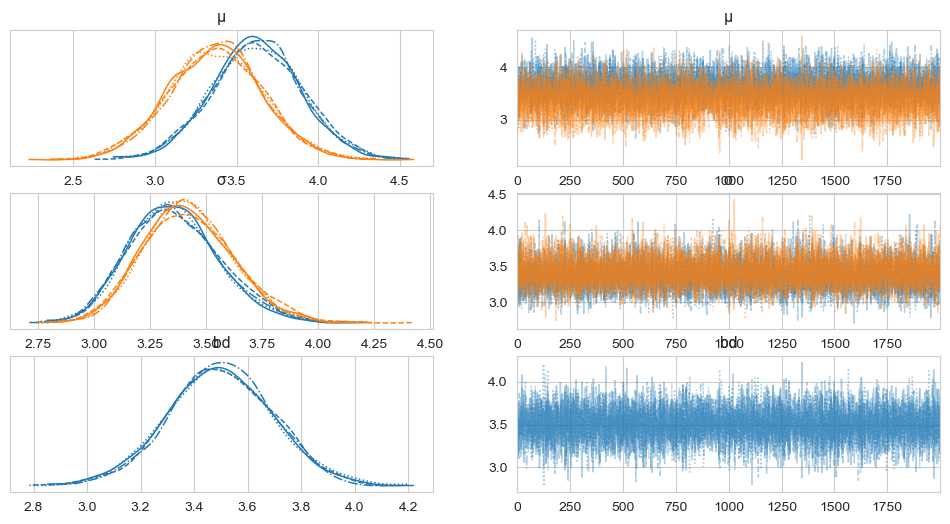

In [18]:
az.plot_trace(trace_lda,compact=True);

In [19]:
trace_lda

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [20]:
predicted_labels = [1 if i < posterior_lda['bd'].mean() else 0 for i in X_test.sum(axis=1)]

In [21]:
predicted_labels = np.array(predicted_labels)
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [22]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, predicted_labels)

0.61